`Created by Ayushi Dubey`

**Task T1 Model bias (i.e: models giving very high values or low values):** to check that, we only need to run predictions for a list of 1000 diverse molecules in each model and plot the results in a scatter plot.

**Task Description:**

__Pick a model from the list:__

hERG Models:

1. [eos2ta5](https://github.com/ersilia-os/eos2ta5)

2. [eos30f3](https://github.com/ersilia-os/eos30f3)

3. [eos30gr](https://github.com/ersilia-os/eos30gr)

4. [eos4tcc](https://github.com/ersilia-os/eos4tcc)

ADME Models:

1. [eos74bo](https://github.com/ersilia-os/eos74bo)

2. [eos31ve](https://github.com/ersilia-os/eos31ve)

3. [eos9tyg](https://github.com/ersilia-os/eos9tyg)

4. [eos6oli](https://github.com/ersilia-os/eos6oli)

- Using [this](https://github.com/GemmaTuron/model-validation-example/tree/main) repository as an example, create a repository in your GitHub account with the appropriate structure (for example, the repository will contain a README file that will explain what is in there, steps to run/reproduce your work, the necessary datasets and folders, licenses and gitignore files)

- Download and run the selected model from Ersilia and make sure it works

- Select a list of 1000 molecules from public repositories and make sure they are represented as standard SMILES 

- Run predictions for the 1000 molecules, create the necessary plots and explain the results you are obtaining

**Model Chosen :** eos30gr

# Importing Necessary Libraries

All the necessary libraries used in the notebook are imported in the below cell. The functions - `standardise_smiles` and `standardise_inchikey` described in the `src` directory are also imported below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.decomposition import PCA
import sys
sys.path.append('../src')
from smiles_processing import standardise_smiles
from inchikey_processing import standardise_inchikey

# Data Preprocessing

The dataset was downloaded from ChEMBL in tsv format. Dataset contains 8715 entries. Thus, it is preprocessed to check for null or irrelevant data and satisfy the required format.

## Reading the raw data

In [2]:
df = pd.read_csv('../data/raw_data.tsv', delimiter='\t')

## Exploring the raw data

In [3]:
df.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key
0,CHEMBL1964670,NaN,NaN,Small molecule,NaN,132.16,53.0,53.0,0.32,46.53,...,9,3,1,0,132.0786,0.45,NEUTRAL,C6H12O3,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N
1,CHEMBL3120732,NaN,NaN,Small molecule,NaN,198.27,2.0,3.0,0.57,58.20,...,14,4,2,0,198.1368,-0.39,NEUTRAL,C10H18N2O2,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N
2,CHEMBL44100,NaN,NaN,Small molecule,NaN,179.18,5.0,5.0,0.72,80.36,...,13,5,4,0,179.0695,-0.51,BASE,C8H9N3O2,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N
3,CHEMBL111759,NaN,N-Prenyl Agmatine,Small molecule,NaN,198.31,3.0,11.0,0.81,73.93,...,14,4,5,0,198.1844,1.25,BASE,C10H22N4,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N
4,CHEMBL1968584,NaN,NaN,Small molecule,NaN,140.14,56.0,56.0,0.75,54.37,...,10,3,1,0,140.0473,0.47,ACID,C7H8O3,CC(O)=C1C(=O)CCC1=O,AJIYRXFNAHUXKP-UHFFFAOYSA-N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ChEMBL ID                        8715 non-null   object 
 1   Name                             670 non-null    object 
 2   Synonyms                         1168 non-null   object 
 3   Type                             8715 non-null   object 
 4   Max Phase                        243 non-null    float64
 5   Molecular Weight                 8715 non-null   float64
 6   Targets                          7689 non-null   float64
 7   Bioactivities                    7689 non-null   float64
 8   AlogP                            8715 non-null   float64
 9   Polar Surface Area               8715 non-null   float64
 10  HBA                              8715 non-null   int64  
 11  HBD                              8715 non-null   int64  
 12  #RO5 Violations     

We only require the `Smiles` and `Inchi Key` columns for further analysis. So we remove all the other columns except these.

In [5]:
selected_columns = ['Smiles', 'Inchi Key']
df = df.loc[:, selected_columns]

In [6]:
df.head()

,Smiles,Inchi Key
0,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N
1,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N
2,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N
3,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N
4,CC(O)=C1C(=O)CCC1=O,AJIYRXFNAHUXKP-UHFFFAOYSA-N


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Smiles     8715 non-null   object
 1   Inchi Key  8715 non-null   object
dtypes: object(2)
memory usage: 136.3+ KB


# Standardising Smiles and Inchi Key

We standardise both `Smiles` and `InChiKeys` of the molecules using the functions described in the `src` directory

In [8]:
smiles_list = df['Smiles'].tolist()
standardised_smiles_list = standardise_smiles(smiles_list)
df['standardised_smiles'] = standardised_smiles_list
df

[13:41:20] Can't kekulize mol.  Unkekulized atoms: 3 5
[13:41:20] Can't kekulize mol.  Unkekulized atoms: 3 9
[13:41:20] Can't kekulize mol.  Unkekulized atoms: 3 9
[13:41:20] Can't kekulize mol.  Unkekulized atoms: 3 5
[13:41:20] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 6
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 2 5 9 10 11 12
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 2 5 10 11 12 13
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 6
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 5
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:21] Can't kekulize mol.  Unkekulized atoms: 3 7
[13:41:22] Can't kekulize mol.  Unkekulized atoms: 3 5
[13:41:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9
[13:41:22] Can't kekulize mol.  Un

,Smiles,Inchi Key,standardised_smiles
0,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N,CCOC(=O)CCCO
1,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N,CC(=O)NC1CCC(NC(C)=O)CC1
2,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N,N=C(N)Nc1ccc2c(c1)OCO2
3,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N,CC(C)=CCNC(=N)NCCCCN
4,CC(O)=C1C(=O)CCC1=O,AJIYRXFNAHUXKP-UHFFFAOYSA-N,CC(=O)C1C(=O)CCC1=O
...,...,...,...
8710,CSCC[C@H](N)[11C](=O)O,FFEARJCKVFRZRR-YMNXMHMNSA-N,CSCC[C@H](N)[11C](=O)O
8711,OCCCNC(=S)[S-].[Na+],DKXSDDDDKKDNIP-UHFFFAOYSA-M,OCCCNC(=S)S
8712,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N,[3H]C1(O)C=C(C(=O)O)CC1
8713,[3H][C@](O)(CN)c1ccc(O)c(O)c1,SFLSHLFXELFNJZ-CMIMLBRMSA-N,[3H][C@](O)(CN)c1ccc(O)c(O)c1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Smiles               8715 non-null   object
 1   Inchi Key            8715 non-null   object
 2   standardised_smiles  8697 non-null   object
dtypes: object(3)
memory usage: 204.4+ KB


Since few molecules could not be kekulized, we remove those rows from our dataset as they contain `NULL` entries in the `standardised_smiles` column.

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Smiles,Inchi Key,standardised_smiles
0,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N,CCOC(=O)CCCO
1,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N,CC(=O)NC1CCC(NC(C)=O)CC1
2,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N,N=C(N)Nc1ccc2c(c1)OCO2
3,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N,CC(C)=CCNC(=N)NCCCCN
4,CC(O)=C1C(=O)CCC1=O,AJIYRXFNAHUXKP-UHFFFAOYSA-N,CC(=O)C1C(=O)CCC1=O
...,...,...,...
8692,CSCC[C@H](N)[11C](=O)O,FFEARJCKVFRZRR-YMNXMHMNSA-N,CSCC[C@H](N)[11C](=O)O
8693,OCCCNC(=S)[S-].[Na+],DKXSDDDDKKDNIP-UHFFFAOYSA-M,OCCCNC(=S)S
8694,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N,[3H]C1(O)C=C(C(=O)O)CC1
8695,[3H][C@](O)(CN)c1ccc(O)c(O)c1,SFLSHLFXELFNJZ-CMIMLBRMSA-N,[3H][C@](O)(CN)c1ccc(O)c(O)c1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8697 entries, 0 to 8696
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Smiles               8697 non-null   object
 1   Inchi Key            8697 non-null   object
 2   standardised_smiles  8697 non-null   object
dtypes: object(3)
memory usage: 204.0+ KB


We standardise the `Inchi Key` column also using the function described in the `src` directory.

In [12]:
smiles_list = df['standardised_smiles'].tolist()
standardised_inchikeys_list = standardise_inchikey(smiles_list)
df['standardised_inchikeys'] = standardised_inchikeys_list
df

,Smiles,Inchi Key,standardised_smiles,standardised_inchikeys
0,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N
1,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N,CC(=O)NC1CCC(NC(C)=O)CC1,TVILGUBKPIUIFC-UHFFFAOYSA-N
2,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N,N=C(N)Nc1ccc2c(c1)OCO2,OZINHCFSCQEUPW-UHFFFAOYSA-N
3,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N,CC(C)=CCNC(=N)NCCCCN,VACJHYSOFQSYAC-UHFFFAOYSA-N
4,CC(O)=C1C(=O)CCC1=O,AJIYRXFNAHUXKP-UHFFFAOYSA-N,CC(=O)C1C(=O)CCC1=O,WYBUYWCJZMQESH-UHFFFAOYSA-N
...,...,...,...,...
8692,CSCC[C@H](N)[11C](=O)O,FFEARJCKVFRZRR-YMNXMHMNSA-N,CSCC[C@H](N)[11C](=O)O,FFEARJCKVFRZRR-YMNXMHMNSA-N
8693,OCCCNC(=S)[S-].[Na+],DKXSDDDDKKDNIP-UHFFFAOYSA-M,OCCCNC(=S)S,HSXNXTGUYOUXQI-UHFFFAOYSA-N
8694,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N
8695,[3H][C@](O)(CN)c1ccc(O)c(O)c1,SFLSHLFXELFNJZ-CMIMLBRMSA-N,[3H][C@](O)(CN)c1ccc(O)c(O)c1,SFLSHLFXELFNJZ-CMIMLBRMSA-N


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8697 entries, 0 to 8696
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Smiles                  8697 non-null   object
 1   Inchi Key               8697 non-null   object
 2   standardised_smiles     8697 non-null   object
 3   standardised_inchikeys  8697 non-null   object
dtypes: object(4)
memory usage: 271.9+ KB


Here, the preprocessing is completed. The dataset now contains 8697 entries. We now create a sample dataset of 1000 entries using the sample function. We also rename the column names to `Smiles` and `Inchi_key` for convenience.

# Creating the Sample of 1000 Entries

In [14]:
input_data = df.sample(n=1000, random_state=42)
input_data = input_data[['standardised_inchikeys', 'standardised_smiles']]
input_data.rename(columns={'standardised_inchikeys': 'Inchi_key', 'standardised_smiles': 'Smiles'}, inplace=True)
input_data.reset_index(drop=True, inplace=True)
input_data.to_csv('../data/input_data.csv', index=False)
input_data.head()

,Inchi_key,Smiles
0,RAEDEZWVLQSYAR-CLFYSBASSA-N,[O-]/[N+](=N\OCCl)N1CCOCC1
1,UTXDPIGHIUIJIS-UHFFFAOYSA-N,CC(CN)c1cnc[nH]1
2,ODJQKYXPKWQWNK-UHFFFAOYSA-N,O=C(O)CCSCCC(=O)O
3,BWUFFNRDKQQEQQ-GDVGLLTNSA-N,CC1SC(=O)[C@@H]2CCCN2C1=O
4,RSXWJXPKLRYMHW-UHFFFAOYSA-N,Cc1nc([N+](=O)[O-])cn1CCO


In [15]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Inchi_key  1000 non-null   object
 1   Smiles     1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


# Running the Model on the Input Data

The model is run on the terminal on the input data using the following commands:
```
ersilia -v fetch eos30gr
ersilia serve eos30gr
ersilia -v api run -i input_data.csv -o output_data.csv
```

The output after running the model is saved in `output_data.csv` file which is present the `data` directory.

# Model Bias Evaluation

## Exploring the output data

In [16]:
predictions_df = pd.read_csv('../data/output_data.csv')
predictions_df.head()

,key,input,activity10
0,RAEDEZWVLQSYAR-CLFYSBASSA-N,[O-]/[N+](=N\OCCl)N1CCOCC1,0.342822
1,UTXDPIGHIUIJIS-UHFFFAOYSA-N,CC(CN)c1cnc[nH]1,0.183168
2,ODJQKYXPKWQWNK-UHFFFAOYSA-N,O=C(O)CCSCCC(=O)O,0.034653
3,BWUFFNRDKQQEQQ-GDVGLLTNSA-N,CC1SC(=O)[C@@H]2CCCN2C1=O,0.224422
4,RSXWJXPKLRYMHW-UHFFFAOYSA-N,Cc1nc([N+](=O)[O-])cn1CCO,0.136492


In [17]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         1000 non-null   object 
 1   input       1000 non-null   object 
 2   activity10  1000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 23.6+ KB


The output data contains the `key` - which is the `InChiKey`, the `input` - which is the `Smiles` string and the `activity10` column which contains the `probability of hERG blockade`. 

## Visualizing the predictions

### Distribution of predicted probabilities

The following histogram depicts the distribution of the predicted probabilites.

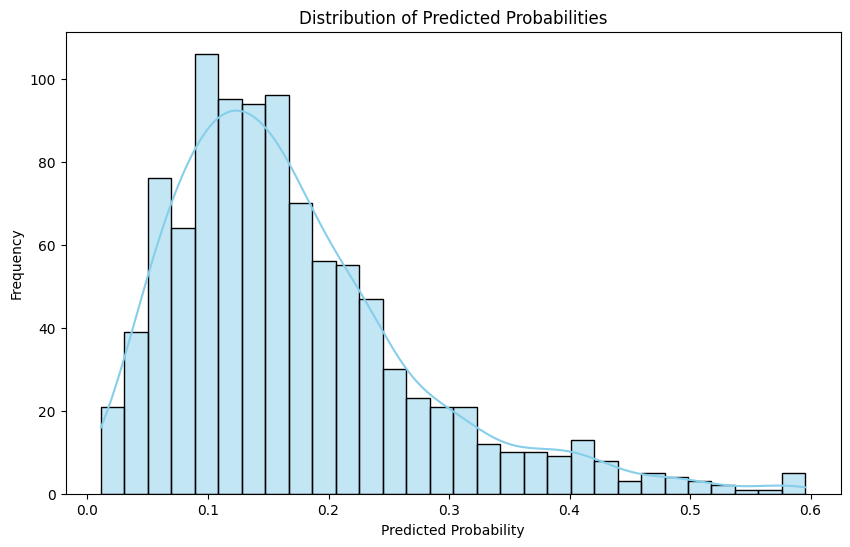

In [18]:
# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['activity10'], bins=30, kde=True, color='skyblue')

# Set plot labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')

#Save the plot
figure_path = '../figures/model_bias/distribution_of_predicted_probabilites.png'
plt.savefig(figure_path)

# Show the plot
plt.show()

From the histogram, we can conclude than most molecules have the predicted probability of being a hERG blocker as 0.1, which means that a majority of the molecules might not be hERG blockers in the selected dataset.

### Distribution of molecules by probability range

We create a pie chart to visualize the percentage of molecules in a particular probability range.

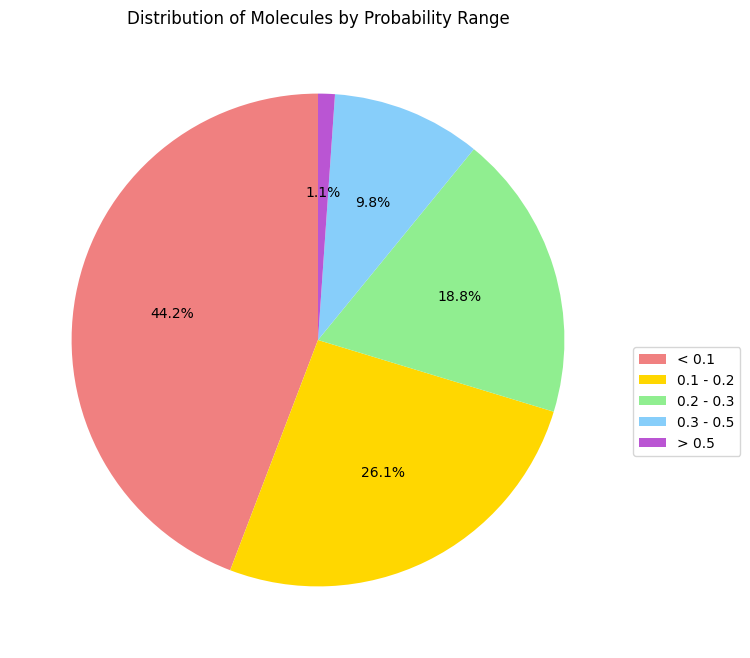

In [19]:
predictions_df['Probability Range'] = pd.cut(predictions_df['activity10'], bins=[-float('inf'), 0.1, 0.2, 0.3, 0.5, float('inf')],
                                            labels=['< 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.5', '> 0.5'])

# Count the number of molecules in each probability range
counts = predictions_df['Probability Range'].value_counts()

# Define colors for each category
colors = ['lightcoral', 'gold', 'lightgreen', 'lightskyblue', 'mediumorchid']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, autopct='%1.1f%%', startangle=90, colors=colors)

# Create a legend outside the pie chart
plt.legend(labels=['< 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.5', '> 0.5'], loc='upper left', bbox_to_anchor=(1, 0.5))

plt.title('Distribution of Molecules by Probability Range')

#Save the plot
figure_path = '../figures/model_bias/distribution_of_molecules_by_probability_range.png'
plt.savefig(figure_path)

plt.show()

### Molecules with highest predicted probabilities

In [20]:
# Sort the DataFrame by predicted probabilities in descending order
top_predictions = predictions_df.sort_values(by='activity10', ascending=False).head(10)

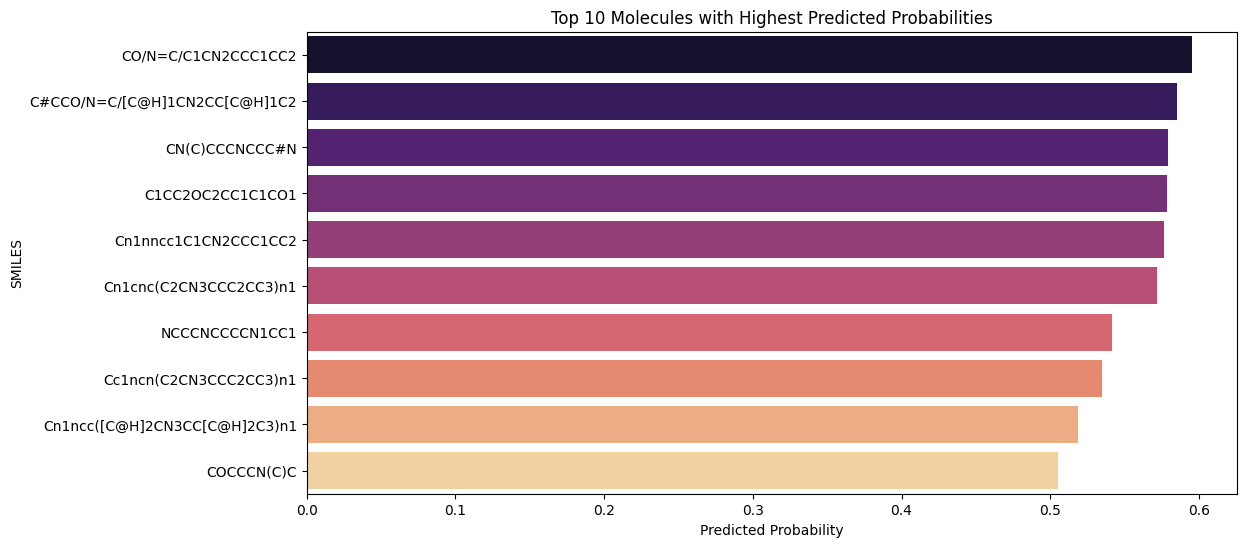

In [21]:
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='activity10', y='input', hue='input', data=top_predictions, palette='magma', legend=False)

# Set plot labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('SMILES')
plt.title('Top 10 Molecules with Highest Predicted Probabilities')

#Save the plot
figure_path = '../figures/model_bias/molecules_with_highest_predicted_probabilities.png'
plt.savefig(figure_path)

# Show the plot
plt.show()

The above visualization depicts the top ten molecules with the highest probability of being a hERG blockade.

### Molecules with lowest predicted probabilities

In [22]:
# Sort the DataFrame by predicted probabilities in descending order
low_predictions = predictions_df.sort_values(by='activity10', ascending=False).tail(10)

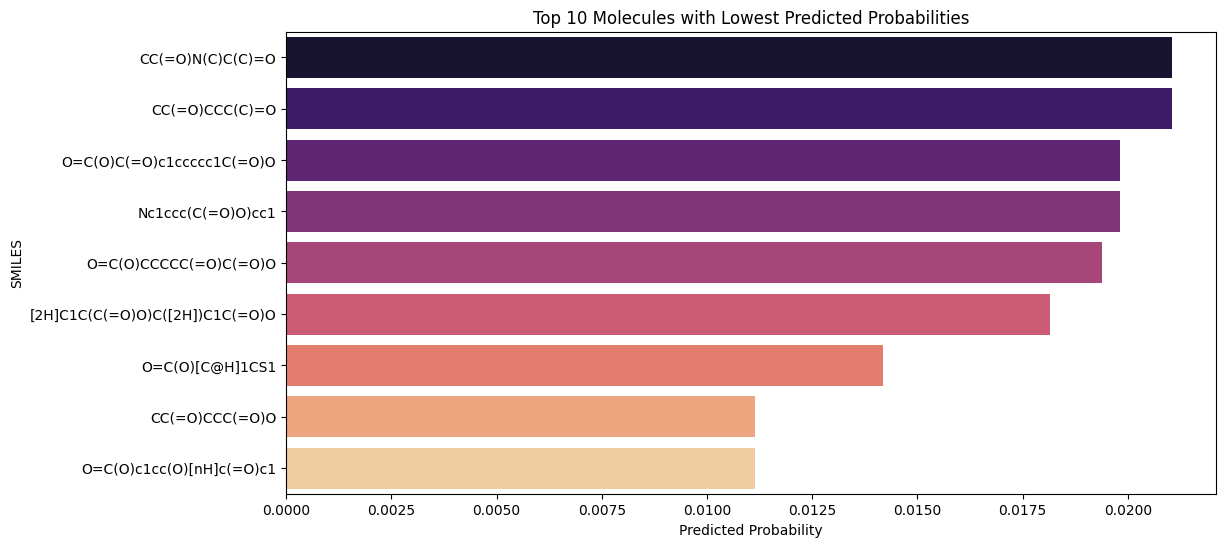

In [23]:
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='activity10', y='input', hue='input', data=low_predictions, palette='magma', legend=False)

# Set plot labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('SMILES')
plt.title('Top 10 Molecules with Lowest Predicted Probabilities')

#Save the plot
figure_path = '../figures/model_bias/molecules_with_lowest_predicted_probabilities.png'
plt.savefig(figure_path)

# Show the plot
plt.show()

The above visualization depicts the top ten molecules with the least probability of being a hERG blockade.

### Molecular structures of Blockers and Non-Blockers

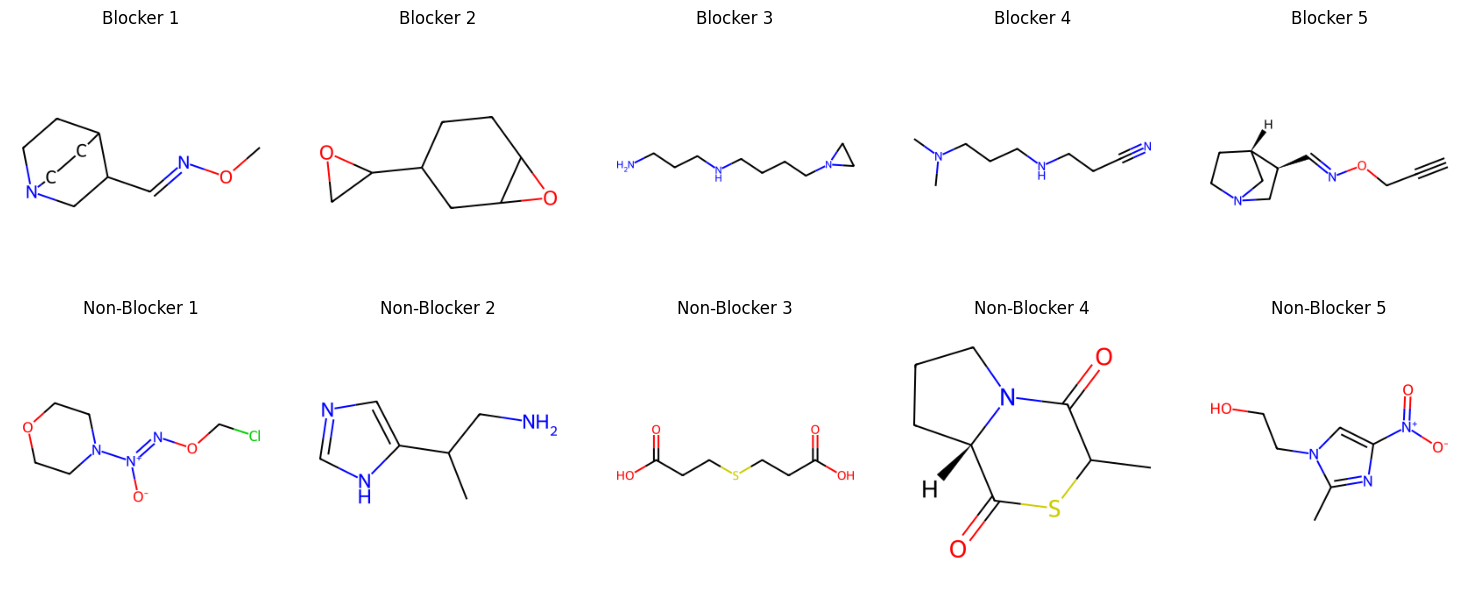

In [24]:
# Extract SMILES of top 5 HERG blockers and non-blockers
top_blockers_smiles = predictions_df[predictions_df['activity10'] >= 0.5]['input'].head(5).tolist()
top_non_blockers_smiles = predictions_df[predictions_df['activity10'] < 0.5]['input'].head(5).tolist()

# Convert SMILES to molecules
top_blockers_molecules = [Chem.MolFromSmiles(smiles) for smiles in top_blockers_smiles]
top_non_blockers_molecules = [Chem.MolFromSmiles(smiles) for smiles in top_non_blockers_smiles]

# Generate 2D depictions
blockers_images = [Draw.MolToImage(mol, size=(300, 300)) for mol in top_blockers_molecules]
non_blockers_images = [Draw.MolToImage(mol, size=(300, 300)) for mol in top_non_blockers_molecules]

# Plot the structures
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(blockers_images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Blocker {i+1}')

    axes[1, i].imshow(non_blockers_images[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Non-Blocker {i+1}')

plt.tight_layout()

#Save the plot
figure_path = '../figures/model_bias/molecular_structures_of_blockers_and_non_blockers.png'
plt.savefig(figure_path)

plt.show()

### Scatter plot using Morgan Fingerprints

From the visualizations created above, it can be seen that the highest probability of a molecule being a hERG blocker is around 0.6. Therefore we create a threshold of 0.5 to check what percentage of molecules have a probability of being a hERG blocker more than 0.5 and less than 0.5

Morgan fingerprints are a type of molecular fingerprint used in cheminformatics to encode the structural features of chemical compounds. In this code, we use Morgan fingerprints to represent the structural information of molecules encoded in SMILES format. The fingerprints are calculated for each molecule in the dataset using the RDKit library. Furthermore, we apply PCA to the Morgan fingerprints to reduce the dimensionality to two dimensions.

In [25]:
# Function to calculate Morgan fingerprints
def calculate_morgan_fingerprints(smiles_list):
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=1024) for smiles in smiles_list]
    return fingerprints

# Extract SMILES from 'input' column
smiles_list = predictions_df['input']

# Calculate Morgan fingerprints
fingerprints = calculate_morgan_fingerprints(smiles_list)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fingerprints)

# Add PCA components to DataFrame
predictions_df['PCA1'] = pca_result[:, 0]
predictions_df['PCA2'] = pca_result[:, 1]

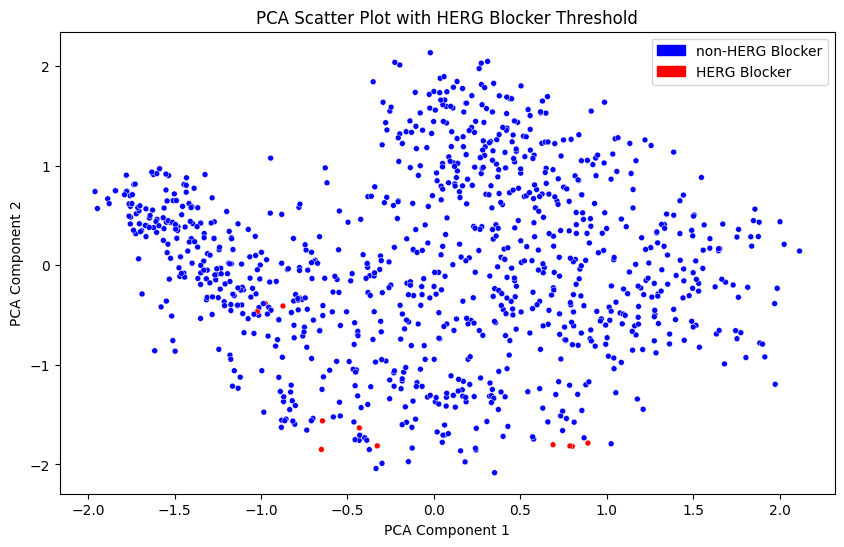

In [26]:
# Create Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=predictions_df, hue=(predictions_df['activity10'] >= 0.5), palette={True: 'red', False: 'blue'}, size=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Scatter Plot with HERG Blocker Threshold')

# Define legend labels and colors
legend_labels = ['non-HERG Blocker', 'HERG Blocker']
legend_colors = ['blue', 'red']

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.legend(handles=legend_patches, loc='upper right')

#Save the plot
figure_path = '../figures/model_bias/scatter_plot_using_morgan_fingerprints.png'
plt.savefig(figure_path)

plt.show()

Each point in the scatter plot represents a molecule, with its position determined by the first two principal components obtained from PCA. Additionally, molecules are colored according to their activity level, with those having a HERG blocking activity of 0.5 or higher labeled as 'HERG Blocker' and colored in red, while those below 0.5 are labeled as 'non-HERG Blocker' and colored in blue.

From the above scatter plot, we can infer that the dataset may be imbalanced with a disproportionately large number of molecules classified as non-HERG blockers (blue dots) compared to HERG blockers (red dots). 

Also, since there is a lack of clear separation or partition between the two classes in the scatter plot, the model may struggle to distinguish between the two classes effectively.

### Distribution of molecules after binarization of outcomes

Now that we have seen that the number of classified hERG blockers is significantly less than the number of non-hERG blockers, let us now visualize the exact percentage of each of these classes.

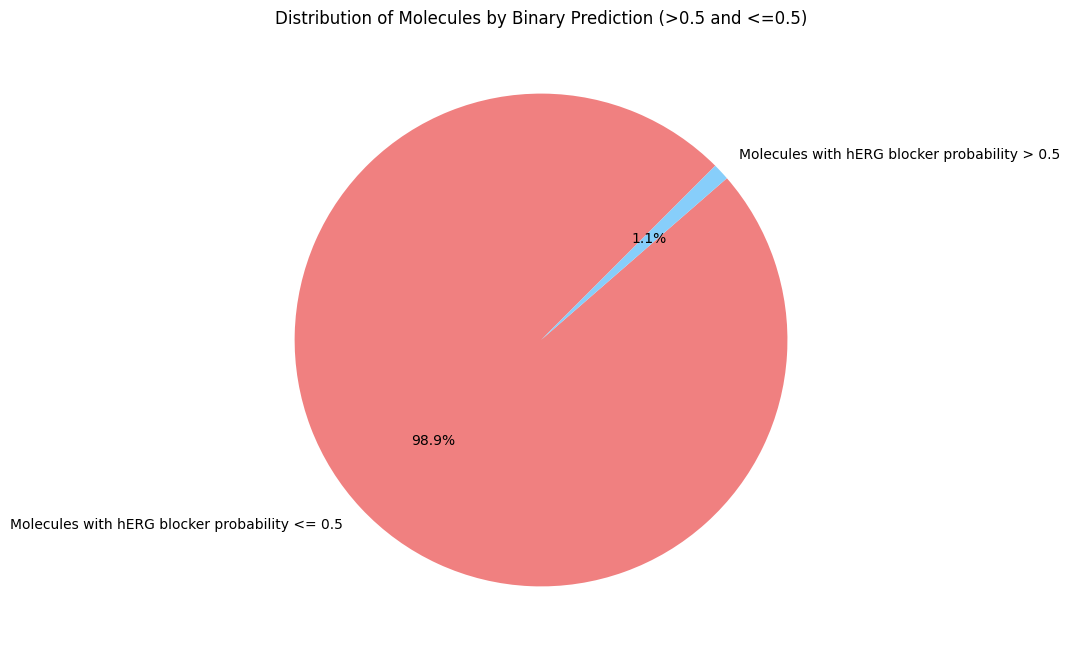

In [27]:
# Binarize the predictions based on the threshold (0.5)
predictions_df['Binary Prediction'] = (predictions_df['activity10'] > 0.5).astype(int)

# Define custom labels
label_mapping = {1: 'Molecules with hERG blocker probability > 0.5',
                 0: 'Molecules with hERG blocker probability <= 0.5'}

# Map the binary predictions to custom labels
predictions_df['Binary Prediction Label'] = predictions_df['Binary Prediction'].map(label_mapping)

# Count the number of molecules in each category
counts = predictions_df['Binary Prediction Label'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=45, colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Molecules by Binary Prediction (>0.5 and <=0.5)')

#Save the plot
figure_path = '../figures/model_bias/distribution_of_molecules_after_binarization.png'
plt.savefig(figure_path)


# Show the plot
plt.show()


# Conclusion

**From the above analysis and visualizations, we can see that from the sample of 1000 molecules, major percentage has a very low probability of being a hERG blocker. And around 1.1% molecules have the probability of being a hERG blocker.**
**This can suggest that:**

**1. Either the model is biased towards predicting the molecule as not being a hERG blocker, or**

**2. The selected dataset is unbalanced and contains only few molecules which are hERG blockers.**